# Imports

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Load Data

In [11]:
df = pd.read_csv("C:\\Users\\pchtc\\RandomProjects\\bike-sharing-demand\\train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Baseline Model

In [38]:
baseline_features = [
    "temp", "atemp", "humidity", "windspeed",
    "season", "holiday", "workingday", "weather"
]

X = df[baseline_features]
y = df["count"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [39]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse, r2


(np.float64(154.61828705937765), 0.2757033009386364)

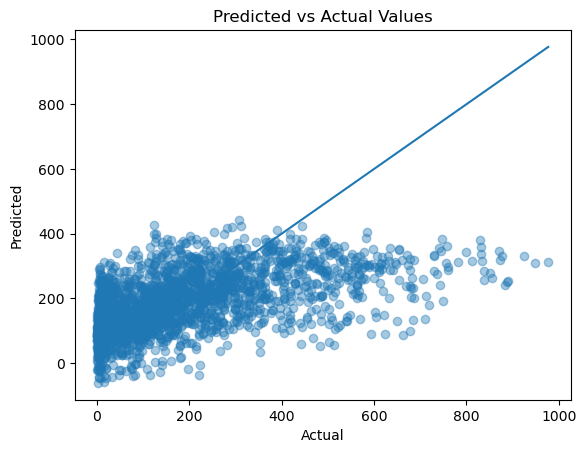

In [41]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Values")
plt.show()


The baseline linear regression model performs modestly, with an RMSE of approximately 155 and an R² of 0.28. This result highlights the limitations of using raw features alone and motivates the use of feature engineering to better capture temporal and environmental patterns in bike rental demand.

# Let's try improving the capabalities of our features with feature engineering

In [46]:
df["datetime"] = pd.to_datetime(df["datetime"])

df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

In [47]:
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


Time-based variables such as hour of day and month of year are cyclical in nature. For example, hour 23 is "close" to hour 0, but a raw numeric encoding does not capture this relationship. To preserve this cyclic structure, I apply sine and cosine transformations. This allows the model to learn smooth periodic patterns in demand without obvious discontinuities.

In [48]:
df["temp_humidity"] = df["temp"] * df["humidity"]
df["high_humidity"] = (df["humidity"] > 70).astype(int)
df["bad_weather"] = (df["weather"] >= 3).astype(int)

df["log_count"] = np.log1p(df["count"])



# Let's train our new model now

In [49]:
features = [
    "temp", "humidity", "windspeed",
    "season", "holiday", "workingday",
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
    "is_weekend",
    "temp_humidity",
    "high_humidity",
    "bad_weather"
]

X = df[features]
y = df["log_count"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [50]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(0.901922173768757), 0.6048280045171777)

In [51]:
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": ridge.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df


,feature,coefficient
7,hour_cos,-1.011324
6,hour_sin,-1.002488
13,bad_weather,-0.556858
3,season,0.225152
9,month_cos,-0.221296
12,high_humidity,-0.172812
10,is_weekend,0.051964
4,holiday,-0.041701
8,month_sin,0.031246
5,workingday,-0.010262


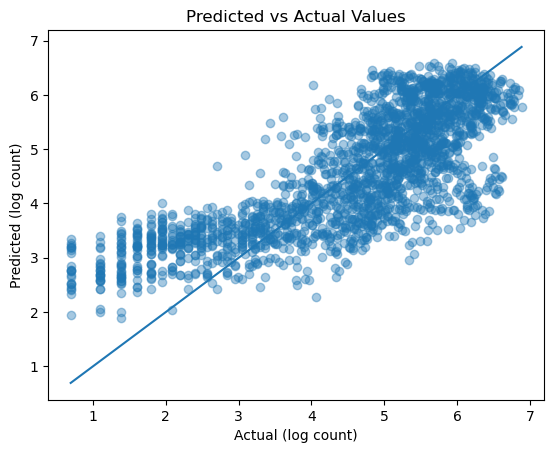

In [52]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual (log count)")
plt.ylabel("Predicted (log count)")
plt.title("Predicted vs Actual Values")
plt.show()
